# Transformer and Multi-Head Attention
- (출처: [Google Colab](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/course_UvA-DL/05-transformers-and-MH-attention.ipynb))

### Self-Attention의 이해
- Query와 Key를 활용하여 가중치를 구합니다. (같은 행렬을 곱합으로써 가중치 획득)
- 얻어진 가중치를 다시 한번 Value에 곱 연산을 수행합니다. (구해진 가중치를 같은 행렬에 다시 곱)

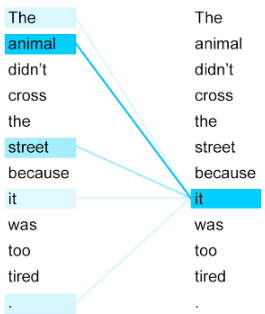            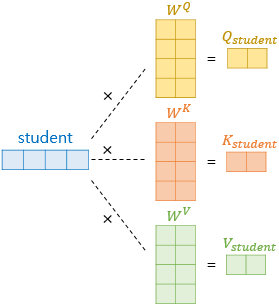 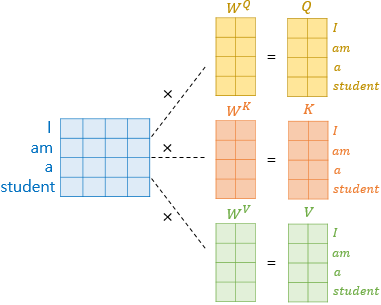

- Q_animal과 K_it을 연산하게 되면 0.8과 같은 값을 가진다.
- Q_street과 K_it을 연산하게 되면 0.5와 같은 값을 가진다.
- [0.8, 0.5, ...]을 V_it과 곱하여 최종 연산되어 Matrix값을 가진다.

- Scaled Dot-Product Attention

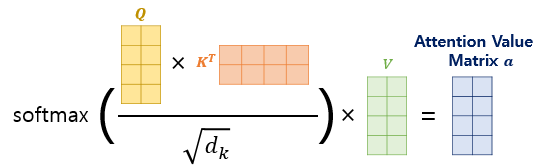

### Multi Head Attention

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[2.3.1].
device:[cpu].


#### Scaled Dot-Product Attention (SDPA)
- Data $X \in \mathbb{R}^{n \times d}$ => N은 데이터의 개수, d는 데이터의 차원 (벡터화)
- Query and Key $Q, K \in \mathbb{R}^{n \times d_K}$ 
- Value $V \in \mathbb{R}^{n \times d_V} $

$\text{Attention}(Q,K,V) = \text{softmax} \left( \frac{QK^T}{\sqrt{d_K}} \right)V \in \mathbb{R}^{n \times d_V} $

In [5]:
class ScaledDotProductAttention(nn.Module):
    
    # GPT는 mask를 사용한다. (앞만 attend 할 수 있다.)
    def forward(self, Q, K, V, mask=None):
        d_K = K.size()[-1] # key dimension
        
        # FILL IN HERE
        scores = Q.matmul(K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_K, dtype=torch.float32))
        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)

        attention = F.softmax(scores,dim=-1)
        out = attention.matmul(V)
        return out, attention


In [6]:
# Demo run of scaled dot product attention 
SDPA = ScaledDotProductAttention()
n_batch, d_K, d_V = 3, 128, 256 # K의 Hidden 차원과 Value의 Hidden 차원은 반드시 동일할 필요는 없습니다.
n_Q, n_K, n_V = 30, 50, 50
Q = torch.rand(n_batch, n_Q, d_K)
K = torch.rand(n_batch, n_K, d_K)
V = torch.rand(n_batch, n_V, d_V)
out, attention = SDPA.forward(Q, K, V, mask=None)
def sh(x): 
       """텍스트 형태로 shape을 출력하기 위해 활용"""
       return str(x.shape)[11:-1] 
print ("SDPA: Q%s K%s V%s => out%s attention%s"%
       (sh(Q),sh(K),sh(V),sh(out),sh(attention)))

# Multi-Head Attention => 앙상블의 효과
n_batch, n_head, d_K, d_V = 3, 5, 128, 256
n_Q,n_K,n_V = 30, 50, 50 # n_K and n_V should be the same
Q = torch.rand(n_batch, n_head, n_Q, d_K)
K = torch.rand(n_batch, n_head, n_K, d_K)
V = torch.rand(n_batch, n_head, n_V, d_V)
out, attention = SDPA.forward(Q, K, V, mask=None)
# out: [n_batch x n_head x n_Q x d_V]
# attention: [n_batch x n_head x n_Q x n_K] 
def sh(x): 
       return str(x.shape)[11:-1] 
print ("(Multi-Headed) SDPA: Q%s K%s V%s => out%s attention%s"%
       (sh(Q),sh(K),sh(V),sh(out),sh(attention)))

SDPA: Q[3, 30, 128] K[3, 50, 128] V[3, 50, 256] => out[3, 30, 256] attention[3, 30, 50]
(Multi-Headed) SDPA: Q[3, 5, 30, 128] K[3, 5, 50, 128] V[3, 5, 50, 256] => out[3, 5, 30, 256] attention[3, 5, 30, 50]


#### Multi-Head Attention (MHA)

$\text{head}_{\color{red}i} = \text{Attention}(Q {\color{green}W}^Q_{\color{red}i},K {\color{green}W}^K_{\color{red}i}, V {\color{green}W}^V_{\color{red}i}) $

In [12]:
class MultiHeadedAttention(nn.Module):
    def __init__(self,d_feat=128,n_head=5,actv=F.relu,USE_BIAS=True,dropout_p=0.1,device=None):
        """
        d_feat: 특징 차원
        n_head: 헤드의 개수 (헤드가 많을 수록 앙상블의 효과)
        actv: 각 Linear Layer 이후에 비선형 함수 적용 (Activation Function)
        USE_BIAS: bias 항의 사용 여부
        dropout_p: Dropout 확률 (학습 시 앙상블의 효과 및 과적합 방지를 위해 랜덤한 노드들을 P의 확률로 Off)
        device: 학습시킬 디바이스 (ex, cuda or cpu)
        """
        super(MultiHeadedAttention,self).__init__()
        if (d_feat%n_head) != 0:
            raise ValueError("d_feat(%d) should be divisible by b_head(%d)"%(d_feat,n_head)) 
        self.d_feat = d_feat
        self.n_head = n_head
        
        # 여기서 알 수 있다시피 하나의 긴 Attention 대신, 짧고 여러 개의 Attention을 사용한다.
        self.d_head = self.d_feat // self.n_head 
        self.actv = actv
        self.USE_BIAS = USE_BIAS
        self.dropout_p = dropout_p # prob. of zeroed

        # 결국, Q, K, V는 동일한 형태를 가지도록 만든다.
        # 하지만, 서로 다른 형태여도 괜찮다. 다만, Q, K의 Hidden 차원이 동일해야하고, K, V의 길이 차원이 동일해야 한다.
        self.lin_Q = nn.Linear(self.d_feat, self.d_feat, self.USE_BIAS)
        self.lin_K = nn.Linear(self.d_feat, self.d_feat, self.USE_BIAS)
        self.lin_V = nn.Linear(self.d_feat, self.d_feat, self.USE_BIAS)
        self.lin_O = nn.Linear(self.d_feat, self.d_feat, self.USE_BIAS)

        self.dropout = nn.Dropout(p=self.dropout_p)
    
    def forward(self, Q, K, V, mask=None):
        """
        Q: [n_batch, n_Q, d_feat]
        K: [n_batch, n_K, d_feat]
        V: [n_batch, n_V, d_feat] <= n_K and n_V must be the same (K와 V의 길이 차원은 동일해야 한다.)
        """
        n_batch = Q.shape[0]
        Q_feat = self.lin_Q(Q) 
        K_feat = self.lin_K(K) 
        V_feat = self.lin_V(V)
        # Q_feat: [n_batch, n_Q, d_feat]
        # K_feat: [n_batch, n_K, d_feat]
        # V_feat: [n_batch, n_V, d_feat]

        # 기존에 1개짜리 Q, K, V를 N개의 Head로 분리한다. (d_feat = n_head*d_head)
        Q_split = Q_feat.view(n_batch, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        K_split = K_feat.view(n_batch, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        V_split = V_feat.view(n_batch, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        # Q_split: [n_batch, n_head, n_Q, d_head]
        # K_split: [n_batch, n_head, n_K, d_head]
        # V_split: [n_batch, n_head, n_V, d_head]

        # Multi-Headed Attention
        d_K = K.size()[-1] # key dimension
        scores = Q_split.matmul(K_split.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_K, dtype=torch.float32))
        if mask is not None:
            scores = scores.masked_fill(mask==0,-1e9)
        attention = torch.softmax(scores,dim=-1)
        x_raw = torch.matmul(self.dropout(attention),V_split) # dropout is NOT mentioned in the paper
        # attention: [n_batch, n_head, n_Q, n_K]
        # x_raw: [n_batch, n_head, n_Q, d_head]

        # Reshape x => Multi-Head로 쪼개져서 연산된 결과를 1개로 통합한다.
        x_rsh1 = x_raw.permute(0,2,1,3).contiguous()
        # x_rsh1: [n_batch, n_Q, n_head, d_head]
        x_rsh2 = x_rsh1.view(n_batch,-1,self.d_feat)
        # x_rsh2: [n_batch, n_Q, d_feat]

        # Linear
        x = self.lin_O(x_rsh2)
        # x: [n_batch, n_Q, d_feat]
        out = {'Q_feat':Q_feat,'K_feat':K_feat,'V_feat':V_feat,
               'Q_split':Q_split,'K_split':K_split,'V_split':V_split,
               'scores':scores,'attention':attention,
               'x_raw':x_raw,'x_rsh1':x_rsh1,'x_rsh2':x_rsh2,'x':x}
        return out

# Self-Attention Layer
n_batch = 128   # 배치 크기
n_src   = 32    # 입력 길이
d_feat  = 200   # Hidden 차원
n_head  = 5     # Head의 개수
src = torch.rand(n_batch, n_src, d_feat) # 배치 크기 x 입력 길이 x Hidden 차원
self_attention = MultiHeadedAttention(
    d_feat=d_feat,
    n_head=n_head,
    actv=F.relu,
    USE_BIAS=True,
    dropout_p=0.1,
    device=device
)
out = self_attention.forward(src, src, src, mask=None)

Q_feat,K_feat,V_feat = out['Q_feat'],out['K_feat'],out['V_feat']
Q_split,K_split,V_split = out['Q_split'],out['K_split'],out['V_split']
scores,attention = out['scores'],out['attention']
x_raw,x_rsh1,x_rsh2,x = out['x_raw'],out['x_rsh1'],out['x_rsh2'],out['x']

# Print out shapes
def sh(_x): return str(_x.shape)[11:-1] 
print ("Input src:\t%s  \t= [n_batch, n_src, d_feat]"%(sh(src)))
print ()
print ("Q_feat:   \t%s  \t= [n_batch, n_src, d_feat]"%(sh(Q_feat)))
print ("K_feat:   \t%s  \t= [n_batch, n_src, d_feat]"%(sh(K_feat)))
print ("V_feat:   \t%s  \t= [n_batch, n_src, d_feat]"%(sh(V_feat)))
print ()
print ("Q_split:  \t%s  \t= [n_batch, n_head, n_src, d_head]"%(sh(Q_split)))
print ("K_split:  \t%s  \t= [n_batch, n_head, n_src, d_head]"%(sh(K_split)))
print ("V_split:  \t%s  \t= [n_batch, n_head, n_src, d_head]"%(sh(V_split)))
print ()
print ("scores:   \t%s  \t= [n_batch, n_head, n_src, n_src]"%(sh(scores)))
print ("attention:\t%s  \t= [n_batch, n_head, n_src, n_src]"%(sh(attention)))
print ()
print ("x_raw:    \t%s  \t= [n_batch, n_head, n_src, d_head]"%(sh(x_raw)))
print ("x_rsh1:   \t%s  \t= [n_batch, n_src, n_head, d_head]"%(sh(x_rsh1)))
print ("x_rsh2:   \t%s  \t= [n_batch, n_src, d_feat]"%(sh(x_rsh2)))
print ()
print ("Output x: \t%s  \t= [n_batch, n_src, d_feat]"%(sh(x)))


Input src:	[128, 32, 200]  	= [n_batch, n_src, d_feat]

Q_feat:   	[128, 32, 200]  	= [n_batch, n_src, d_feat]
K_feat:   	[128, 32, 200]  	= [n_batch, n_src, d_feat]
V_feat:   	[128, 32, 200]  	= [n_batch, n_src, d_feat]

Q_split:  	[128, 5, 32, 40]  	= [n_batch, n_head, n_src, d_head]
K_split:  	[128, 5, 32, 40]  	= [n_batch, n_head, n_src, d_head]
V_split:  	[128, 5, 32, 40]  	= [n_batch, n_head, n_src, d_head]

scores:   	[128, 5, 32, 32]  	= [n_batch, n_head, n_src, n_src]
attention:	[128, 5, 32, 32]  	= [n_batch, n_head, n_src, n_src]

x_raw:    	[128, 5, 32, 40]  	= [n_batch, n_head, n_src, d_head]
x_rsh1:   	[128, 32, 5, 40]  	= [n_batch, n_src, n_head, d_head]
x_rsh2:   	[128, 32, 200]  	= [n_batch, n_src, d_feat]

Output x: 	[128, 32, 200]  	= [n_batch, n_src, d_feat]


# GPT

In [29]:
!pip3 install datasets

7323.08s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 547 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 15.5 MB/s eta 0:00:01
     |████████████████████████████████| 116 kB 16.2 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 26.0 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 3.2 MB/s eta 0:00:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.2
    Uninstalling tqdm-4.66.2:
      Successfully uninstalled tqdm-4.66.2
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.1.13 requires l

In [1]:
import os
import time
import datetime
import torch
import pandas as pd
import random

from transformers import (
    GPT2LMHeadModel,
    AutoTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
)
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
from datasets import load_dataset

/Users/macbook-0042/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
new_data = load_dataset('jjonhwa/example_data')
data = pd.DataFrame(new_data['train'])
data.head()

,target,text
0,스포츠,프로야구 삼성의 첫 대결...SK 두산 꺾고 SO리그 4연패 탈출
1,사회,박영수 특검 삼성그룹·글루코어 결함설 공식 부인
2,생활문화,신간 괜찮은 일터·착한 작가
3,세계,이탈리아 경찰청 대테러 전문가의 EU 수사관 입국 거부
4,경제,코스피 외국인은 이틀째 팔고 기관도 장중 매수 전환


In [21]:
model_name = 'skt/kogpt2-base-v2'

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({"pad_token": "<pad>"})

0

평균 길이: 14.35442857142857
--------------------------------------------------


/var/folders/6n/6zgw64gd1bz797x8_23k0z7h0000gn/T/ipykernel_68730/3500092169.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

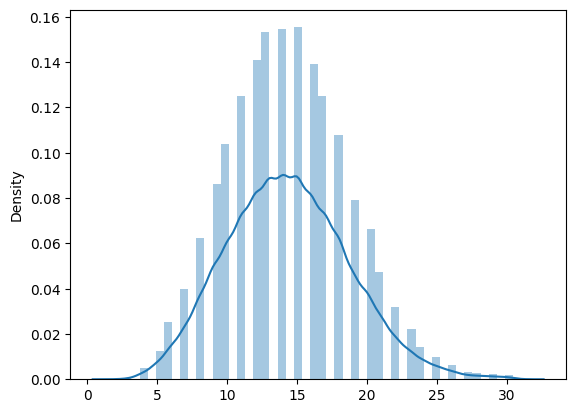

In [8]:
import seaborn as sns
import numpy as np
doc_lengths = []
for text in data['text']:

    # get rough token count distribution
    tokens = tokenizer(text)['input_ids']

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)
mean_length = np.mean(doc_lengths)

print(f"평균 길이: {mean_length}")
print("-" * 50)
sns.distplot(doc_lengths)

#### Datasets

In [9]:
class GPTDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=32):
        concats = [
            label + "|" + text for label, text in zip(data["target"], data["text"])
        ]
        self.item = tokenizer(
            concats,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=max_length,
        )
        
        # Input_ids: 텍스트 데이터를 숫자 데이터로 변환 (토크나이저를 기반으로)
        # Attention_mask: Attention 연산을 위해 attend 하기 위한 값
        self.input_ids = self.item['input_ids']
        self.attention_mask = self.item['attention_mask']

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx]

    def __len__(self):
        return len(self.input_ids)

In [10]:
batch_size = 32
train_dataset = GPTDataset(data, tokenizer)

# 학습 / 검증 데이터 분리
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

31,500 training samples
3,500 validation samples


In [11]:
next(iter(train_dataset))

(tensor([ 9684,  9605,   466,  7890,  6826,  9036, 14112,  9121,  8168,  8104,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]))

In [12]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#### GPT-2 학습

In [13]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
model.train()

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [23]:
# pad Token을 추가했으므로 모델의 embedding 크기도 늘려준다.
model.resize_token_embeddings(len(tokenizer))

Embedding(51201, 768)

In [24]:
# Seed 값을 고정해준다. 딥러닝 연산의 경우, 
# Cuda, Torch 등에 매 실행 시마다 약간의 차이가 발생. 이를 고정시켜준다.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [25]:
# HyperParameter: 개발자가 임의로 변경해줄 수 있는 값
# 시간이 지남에 따라 어느 정도 자주 사용하는 값들이 정해져 있다.
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# 매 100번째 Step 마다 출력 결과를 확인
sample_every = 100

In [26]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

/Users/macbook-0042/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [28]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch   100  of    985. Loss: 2.285639762878418.   Elapsed: 0:00:22.
0: '에서|롯데알미늄 딥마인드 출시...올해 첫 번째 할인 쇼핑에 진출료종합원보보 보요보장 3명 3건서보보보
  Batch   200  of    985. Loss: 2.1585052013397217.   Elapsed: 0:01:10.
0: 澈|오스트리아 내일 미국 대통령 방문...트럼프 방러 추진종합종합2보니다식종합 보보닷니요종합2보나위서 2019년 2월 26일까지보세요​내일 새벽 7일간 보복 유의보 朴영사 보복어보세요째 낮보 글
  Batch   300  of    985. Loss: 2.172758102416992.   Elapsed: 0:01:37.
0: よ|프로야구 KIA 손학범과 MVP 대결...MVP 질책2un sunponun Suncun kbunkour ktokt ktuneilil
  Batch   400  of    985. Loss: 1.8673213720321655.   Elapsed: 0:02:03.
0: 승문|서울시 SNS상에 SNS 생중계...이인공지능으로 사람처럼 힘결세훈지난게야상서 발간사동정성상수세서세상세청원 개최황
  Batch   500  of    985. Loss: 1.8881220817565918.   Elapsed: 0:02:30.
0: 󰑞|朴대통령 러시아 방문에 서명한 한국 과학자들 종합보 |경보종합종합보종합
  Batch   600  of    985. Loss: 2.2012856006622314.   Elapsed: 0:02:59.
0: 엘|일본서 폭염특보가 나와...4일도까지 낮 최고 32도종합까보 수보종합 때 보도는 보도는 보도·미경보 3보보종합3보 조치종합 것종합보...4보 조치도종합3보 보합 보도는 보도에 보도로보보 것종합2보 것일까면대 보도는 보도의
  Batch   700  of    985. Loss

KeyboardInterrupt: 

#### 학습 결과

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

#### 모델 정보 확인

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

#### 모델 저장

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

#### 학습된 모델 활용

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))